In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from nmse_utils import *
from averaging_utils import *
import glob

import warnings

warnings.filterwarnings("ignore")

### Parameters

In [3]:
sname = ""
CESM_output_dir = ""
case_name = ""
component = ""
start_date = ""
end_date = ""

In [3]:
print(start_date)
print(end_date)
print(CESM_output_dir)
print(case_name)
print(component)

In [ ]:
dat = xr.open_mfdataset(
    CESM_output_dir + "/" + case_name + "/" + component + "/proc/tseries/*.PSL*.nc"
)

### Read in validation data and other CMIP models for comparison (precomputed)

In [4]:
# This will need to be changed if we have a common repo
validpath = "/glade/campaign/cgd/cas/islas/python_savs/CUPID/PSL_validation/"
validpath_old = (
    "/glade/campaign/cgd/cas/islas/python_savs/CUPID/NMSE/validation_data_example/"
)

# ---ERA5
era5 = xr.open_dataset(validpath_old + "PSL_ERA5.nc")
# era5 = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/CUPID/NMSE/validation_data_example/PSL_ERA5.nc")
era5 = era5 / 100.0  # convert to hPa

# ---CESM2
lens2 = xr.open_dataset(validpath_old + "PSL_LENS2.nc")
lens2 = lens2 / 100.0  # convert to hPa
lens2["lon"] = era5.lon
lens2["lat"] = era5.lat

# ---CMIP6
modelfiles = sorted(glob.glob(validpath_old + "CMIP6/*.nc"))
datcmip6 = [xr.open_dataset(ifile).mean("M") for ifile in modelfiles]
datcmip6 = xr.concat(datcmip6, dim="model")
datcmip6 = datcmip6 / 100.0
datcmip6["lon"] = era5.lon
datcmip6["lat"] = era5.lat

### Read in the current case

In [20]:
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing/"
case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"
component = "atm"

In [22]:
dat

<xarray.DataArray 'PSL' (time: 1200, ncol: 48600)> Size: 233MB
dask.array<truediv, shape=(1200, 48600), dtype=float32, chunksize=(1, 48600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 10kB 0001-01-16 12:00:00 ... 0100-12-16 12:00:00
Dimensions without coordinates: ncol

In [21]:
# Need to change file paths here to be read in using the parameters thing
dat = xr.open_mfdataset(
    CESM_output_dir + "/" + case_name + "/" + component + "/proc/tseries/*.PSL*.nc"
)
dat = dat.sel(time=slice(start_date, end_date))

dat = dat.PSL / 100.0
dat["lon"] = era5.lon
dat["lat"] = era5.lat

# --Compute seasonal and annual means
dat = seasonal_climatology_weighted(dat).load()

ValueError: cannot add coordinates with new dimensions to a DataArray

### Compute the NMSE

In [9]:
nmse_dat = []
nmse_cesm2 = []
nmse_cmip6 = []
for ivar in era5.data_vars:
    nmse_dat.append(nmse(era5[ivar], dat[ivar]))
    nmse_cesm2.append(nmse(era5[ivar], lens2[ivar]))
    nmse_cmip6.append(nmse(era5[ivar], datcmip6[ivar]))
nmse_dat = xr.merge(nmse_dat)
nmse_cesm2 = xr.merge(nmse_cesm2)
nmse_cmip6 = xr.merge(nmse_cmip6)

### Set up the plot panel

In [10]:
def plotnmse(fig, cmip6, cesm2, cesm3, x1, x2, y1, y2, titlestr):
    ax = fig.add_axes([x1, y1, x2 - x1, y2 - y1])

    cmip6 = cmip6.sortby(cmip6, ascending=False)
    binedges = np.arange(0, cmip6.size, 1)
    ax.bar(
        binedges,
        cmip6,
        width=1,
        bottom=0,
        edgecolor="black",
        color="gray",
        label="CMIP6",
    )

    ax.plot(cmip6.size + 1, cesm3, "o", color="blue", label="THIS RUN")

    ax.fill_between(
        np.arange(0, cmip6.size + 3, 1) - 0.5,
        np.arange(0, cmip6.size + 3, 1) * 0 + np.array(cesm2.min()),
        np.arange(0, cmip6.size + 3, 1) * 0 + np.array(cesm2.max()),
        color="salmon",
        alpha=0.5,
        label="LENS2",
    )

    ax.set_xlim(-0.5, cmip6.size + 2 - 0.5)
    ax.set_xticks([])
    ax.set_ylabel("NMSE", fontsize=14)
    ax.set_title(titlestr, fontsize=16)

    ax.legend()

    return ax

Text(0.5, 0.96, 'Validation data = ERA5 1979-01-01 to 2023-12-31')

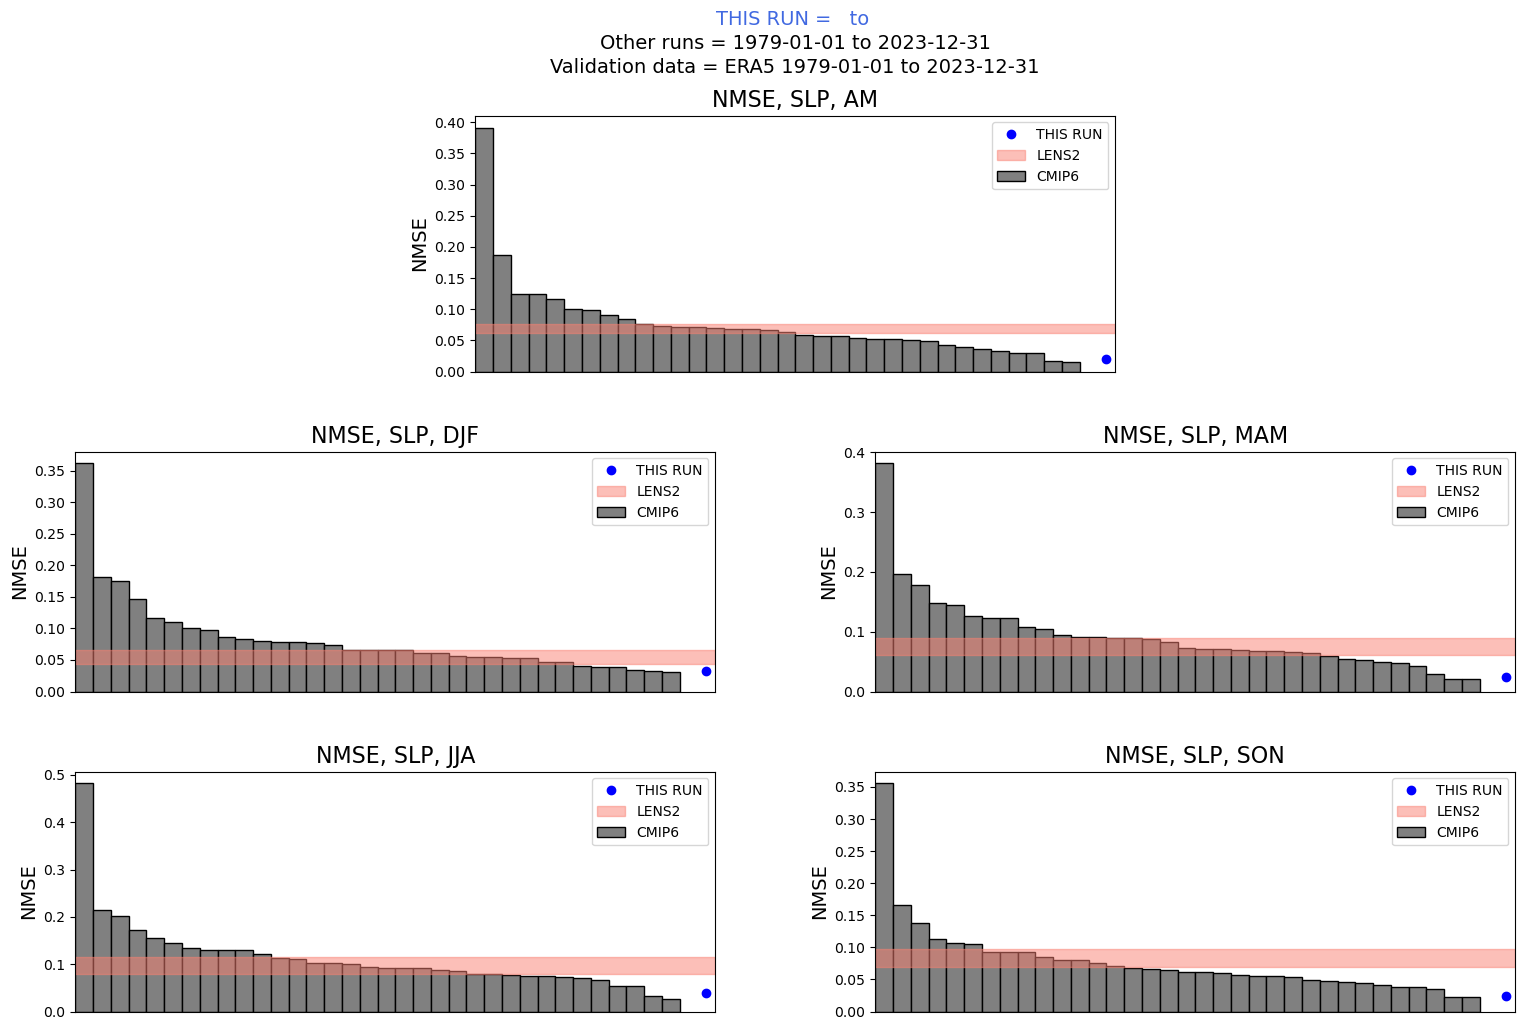

In [17]:
fig = plt.figure(figsize=(16, 16))

ax = plotnmse(
    fig,
    nmse_cmip6.AM,
    nmse_cesm2.AM,
    nmse_dat.AM,
    0.3,
    0.7,
    0.77,
    0.93,
    "NMSE, SLP, AM",
)
ax = plotnmse(
    fig,
    nmse_cmip6.DJF,
    nmse_cesm2.DJF,
    nmse_dat.DJF,
    0.05,
    0.45,
    0.57,
    0.72,
    "NMSE, SLP, DJF",
)
ax = plotnmse(
    fig,
    nmse_cmip6.MAM,
    nmse_cesm2.MAM,
    nmse_dat.MAM,
    0.55,
    0.95,
    0.57,
    0.72,
    "NMSE, SLP, MAM",
)
ax = plotnmse(
    fig,
    nmse_cmip6.JJA,
    nmse_cesm2.JJA,
    nmse_dat.JJA,
    0.05,
    0.45,
    0.37,
    0.52,
    "NMSE, SLP, JJA",
)
ax = plotnmse(
    fig,
    nmse_cmip6.SON,
    nmse_cesm2.SON,
    nmse_dat.SON,
    0.55,
    0.95,
    0.37,
    0.52,
    "NMSE, SLP, SON",
)

fig.text(
    0.5,
    0.99,
    "THIS RUN = " + case_name + " " + start_date + " to " + end_date,
    ha="center",
    va="center",
    fontsize=14,
    color="royalblue",
)
fig.text(
    0.5,
    0.975,
    "Other runs = 1979-01-01 to 2023-12-31",
    ha="center",
    va="center",
    fontsize=14,
)
fig.text(
    0.5,
    0.96,
    "Validation data = ERA5 1979-01-01 to 2023-12-31",
    ha="center",
    va="center",
    fontsize=14,
)